## 1. Загрузка и предобработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
tt = pd.read_csv('/home/bold/task_about_time.tsv', sep='\t')
tt.head(3)

,worker,project_id,task_id,resolution_type,start_ts,end_ts
0,login1,1,task_1,resolution_1,1576865064,1576867011
1,login1,2,task_2,resolution_1,1576837986,1576838385
2,login1,1,task_3,resolution_1,1576078746,1576079378


Преобразование timestamp в datetime и вычисление трудоёмкости (длительности) задания

In [3]:
tt['start_ts'] = pd.to_datetime(tt['start_ts'],unit='s')
tt['end_ts'] = pd.to_datetime(tt['end_ts'],unit='s')
tt['dur'] = tt['end_ts'] - tt['start_ts']
tt['dur'] = tt['dur'].dt.seconds

## 2. EDA

Формирование таблицы характеристик набора данных в разрезе категориальных признаков

In [4]:
pr1 = tt[tt['project_id'] == 1]['dur'].describe().to_frame()
pr1.columns = ['project_1']
pr2 = tt[tt['project_id'] == 2]['dur'].describe().to_frame()
pr2.columns = ['project_2']

res_1 = tt[tt['resolution_type'] == 'resolution_1']['dur'].describe().to_frame()
res_1.columns = ['resolution_1']
res_2 = tt[tt['resolution_type'] == 'resolution_2']['dur'].describe().to_frame()
res_2.columns = ['resolution_2']

tot = tt['dur'].describe().to_frame()
tot.columns = ['total']

des = pr1.join(pr2)\
         .join(res_1)\
         .join(res_2)\
         .join(tot)

des

,project_1,project_2,resolution_1,resolution_2,total
count,3741.000000,1207.000000,4526.000000,422.000000,4948.000000
mean,1017.978081,969.835957,1052.348431,511.656398,1006.234438
std,1327.397732,1208.320154,1286.601334,1334.244180,1299.402243
min,6.000000,10.000000,10.000000,6.000000,6.000000
25%,208.000000,261.000000,268.250000,22.000000,221.000000
50%,521.000000,533.000000,576.000000,54.000000,526.000000
75%,1218.000000,1173.000000,1260.750000,185.500000,1203.500000
max,7200.000000,7038.000000,7200.000000,7144.000000,7200.000000


Удалений заданий с резолюцией 2, как имеющих признаки выбросов. Их доля в 8,5% позволит считать оставшуюся часть данных репрезентативной.

In [5]:
tt = tt[tt['resolution_type'] != 'resolution_2']

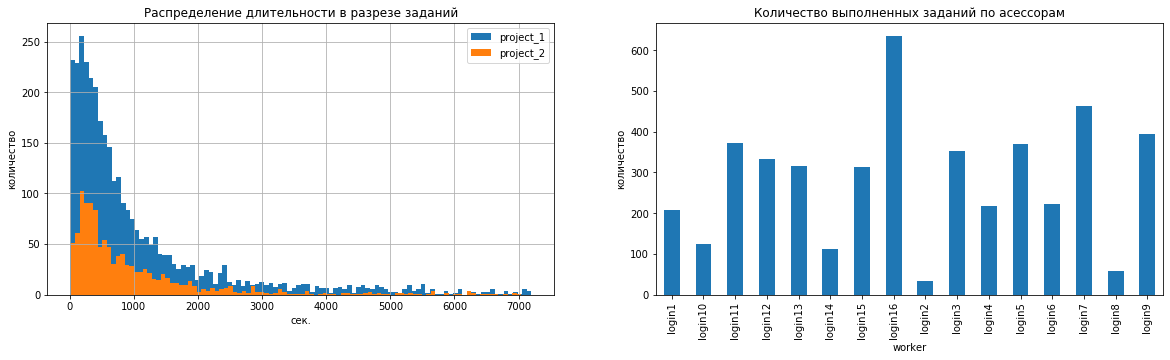

In [6]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

tt[tt['project_id'] == 1]['dur'].hist(bins = 100, ax=ax[0])
tt[tt['project_id'] == 2]['dur'].hist(bins = 100, ax=ax[0])
ax[0].set_title('Распределение длительности в разрезе заданий')
ax[0].legend(('project_1', 'project_2'))
ax[0].set_xlabel('сек.')
ax[0].set_ylabel('количество')

tt.groupby('worker')['dur'].count().plot.bar()

ax[1].set_title('Количество выполненных заданий по асессорам')
ax[1].set_ylabel('количество')

plt.show()

Данные положительно скошены и длительность проектов распределена одинаково. При этом можно выделить TOP-3 ассесоров по количеству выполненных заданий - login16, login7, login9.

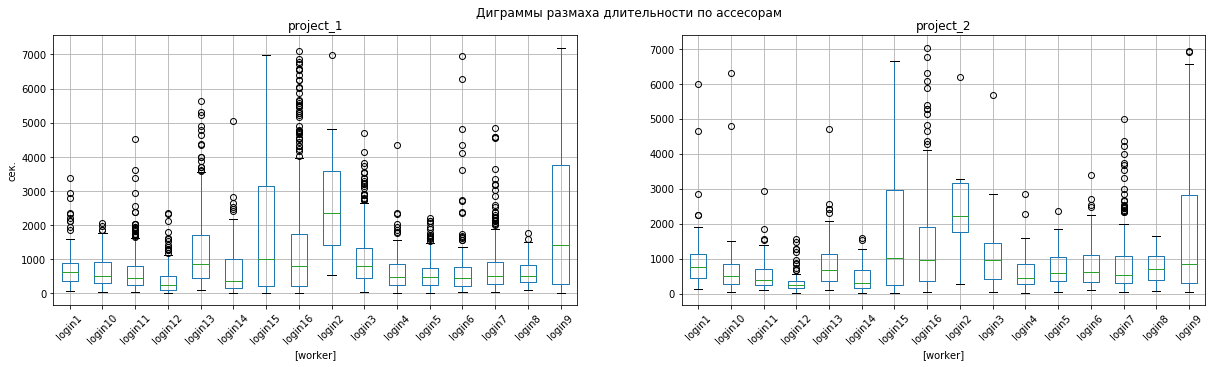

In [7]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

tt[tt['project_id'] == 1][['worker', 'dur']].boxplot(by='worker', rot=45, ax=ax[0])
tt[tt['project_id'] == 2][['worker', 'dur']].boxplot(by='worker', rot=45, ax=ax[1])

ax[0].set_ylabel('сек.')
ax[0].set_title('project_1')
ax[1].set_title('project_2')
fig.suptitle("Диграммы размаха длительности по ассесорам")

plt.show()

In [8]:
data1 = tt[~tt['worker'].isin(['login15','login9'])]['dur']
data2 = tt[tt['worker'].isin(['login15','login9'])]['dur']

stat, p = st.mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Выборки статистически равны')
else:
	print('Нельзя утверждать, что выборки статистически равны')

Statistics=1029057.000, p=0.000
Нельзя утверждать, что выборки статистически равны


Оценка распределения длительности у каждого ассесора позволяет выделить две группы асессоров. В первой - меньшее количество выполненных заданий и присутствие выбросов, у второй, login15 и login9, - большее количество выполненных заданий без аномальных значений. Эти группы являются статистически разными.

Лучшие качественные характеристики позволяют предложить в качестве бенчмарка длительности среднюю длительность второй группы. Дополнительно стоит отметить, что средняя предлагается в противовес  медиане, несмотря на значительную положительную скошенность датасета. В данной случае, на примере лидеров очевидно, что присутствует значительное количество заданий, которые требуют большей трудоёмкости, чем в среднем, соответственно, более высокая оплата будет являться справедливым и стимулирующим фактором для выполения большего объёма заданий.

## 3. Расчёт бенчмарка длительности

In [9]:
print('Медиана длительности для TOP-ассесоров: {} сек.'
      .format(tt[tt['worker'].isin(['login15','login9'])]['dur']
              .mean()))

Медиана длительности для TOP-ассесоров: 2003.262341325811 сек.


## 4. Выводы

В качестве нормируемой трудоёмкости предлагается 2003 секунды.
При условии оплаты N за 30 секунд рабочего времени оплата составит **67N** за задание.